In [1]:
!wget -q https://github.com/emanhamed/Houses-dataset/archive/refs/heads/master.zip

In [2]:
!unzip -q /content/master.zip

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip -q install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [7]:
import wandb
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)
run = wandb.init(project="House_price_by_image")
config = wandb.config
wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [9]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import numpy as np
import glob
import cv2
import os

def load_house_attributes(inputPath):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)

 	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
	# return the data frame
	return df

In [10]:
def load_house_images(df, inputPath):
  # initialize our images array (i.e., the house images themselves)
  images = []
  # loop over the indexes of the houses
  for i in df.index.values:
    # find the four images for the house and sort the file paths,
    # ensuring the four are always in the *same order*
    basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
    housePaths = sorted(list(glob.glob(basePath)))
    # initialize our list of input images along with the output image
    # after *combining* the four input images
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")
    # loop over the input house paths
    for housePath in housePaths:
      # load the input image, resize it to be 32 32, and then
      # update the list of input images
      image = cv2.imread(housePath)
      image = cv2.resize(image, (32, 32))
      inputImages.append(image)
    # tile the four input images in the output image such the first
    # image goes in the top-right corner, the second image in the
    # top-left corner, the third image in the bottom-right corner,
    # and the final image in the bottom-left corner
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]
    # add the tiled image to our set of images the network will be
    # trained on
    images.append(outputImage)
    # return our set of images
  return np.array(images)
# images = load_house_images(df,'/content/Houses-dataset-master/Houses Dataset')

In [11]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import locale
import os

print("[INFO] loading house attributes...")
inputPath = os.path.sep.join(["/content/Houses-dataset-master/Houses Dataset", "HousesInfo.txt"])
df = load_house_attributes(inputPath)
# load the house images and then scale the pixel intensities to the
# range [0, 1]
print("[INFO] loading house images...")
images = load_house_images(df, '/content/Houses-dataset-master/Houses Dataset')

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

[INFO] loading house attributes...
[INFO] loading house images...


In [12]:
len(testImagesX)

91

In [14]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
)

train_data = image_data_generator.flow(
                                       trainImagesX,
                                       trainY,
                                       batch_size=32,
                                       shuffle=True
                                       )

validation_data = image_data_generator.flow(
                                       testImagesX,
                                       testY,
                                       batch_size=91,
                                       shuffle=False
                                       )

In [15]:
mobile_net = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64,64,3),
    pooling ='avg'
    )
for layer in mobile_net.layers[0:-8]:
  layer.trainable = False

my_model = models.Sequential([
    mobile_net,
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(512, activation="relu"),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="linear"),
])

58889256/58889256 [==============================] - 2s 0us/step


In [17]:
my_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.mean_absolute_percentage_error
              )

checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/best_model_house_price_image",
                                            save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = my_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=100 ,
    callbacks=[stop_early, checkpoint, wandb_callbacks]
    )

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 1029.9751

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 23s 1s/step - loss: 1029.9751 - val_loss: 264.4214
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 535.6960

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 6s 785ms/step - loss: 535.6960 - val_loss: 71.6665
Epoch 3/100
8/9 [=========================>....] - ETA: 0s - loss: 379.0113

wandb: Adding directory to artifact (./models)... Done. 5.2s


9/9 [==============================] - 10s 1s/step - loss: 355.8561 - val_loss: 92.7148
Epoch 4/100
8/9 [=========================>....] - ETA: 0s - loss: 172.8223

wandb: Adding directory to artifact (./models)... Done. 2.0s


9/9 [==============================] - 5s 623ms/step - loss: 164.6857 - val_loss: 86.4917
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 80.6631

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 6s 678ms/step - loss: 80.6631 - val_loss: 94.6554
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 90.6253

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 6s 784ms/step - loss: 90.6253 - val_loss: 69.8334
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 91.0618

wandb: Adding directory to artifact (./models)... Done. 2.8s


9/9 [==============================] - 6s 769ms/step - loss: 91.0618 - val_loss: 97.5092
Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 90.5896

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 10s 1s/step - loss: 90.5896 - val_loss: 68.0916
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 71.8822

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 4s 472ms/step - loss: 71.8822 - val_loss: 69.3762
Epoch 10/100
8/9 [=========================>....] - ETA: 0s - loss: 75.6923

wandb: Adding directory to artifact (./models)... Done. 3.4s


9/9 [==============================] - 8s 971ms/step - loss: 75.2224 - val_loss: 70.9430
Epoch 11/100
8/9 [=========================>....] - ETA: 0s - loss: 72.7513

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 453ms/step - loss: 72.2474 - val_loss: 69.7537
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 71.5501

wandb: Adding directory to artifact (./models)... Done. 1.3s


9/9 [==============================] - 4s 540ms/step - loss: 71.5501 - val_loss: 78.3453
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 76.4992

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 5s 567ms/step - loss: 76.4992 - val_loss: 82.6752
Epoch 14/100
9/9 [==============================] - ETA: 0s - loss: 80.4553

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 4s 541ms/step - loss: 80.4553 - val_loss: 76.2075
Epoch 15/100
9/9 [==============================] - ETA: 0s - loss: 62.6928

wandb: Adding directory to artifact (./models)... Done. 2.9s


9/9 [==============================] - 10s 1s/step - loss: 62.6928 - val_loss: 66.6990
Epoch 16/100
8/9 [=========================>....] - ETA: 0s - loss: 55.6365

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 7s 862ms/step - loss: 55.9272 - val_loss: 62.7864
Epoch 17/100
9/9 [==============================] - ETA: 0s - loss: 57.3749

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 4s 545ms/step - loss: 57.3749 - val_loss: 71.4623
Epoch 18/100
9/9 [==============================] - ETA: 0s - loss: 63.7090

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 5s 606ms/step - loss: 63.7090 - val_loss: 63.8692
Epoch 19/100
9/9 [==============================] - ETA: 0s - loss: 52.3168

wandb: Adding directory to artifact (./models)... Done. 4.1s


9/9 [==============================] - 10s 1s/step - loss: 52.3168 - val_loss: 62.3522
Epoch 20/100
8/9 [=========================>....] - ETA: 0s - loss: 62.3693

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 5s 566ms/step - loss: 61.1015 - val_loss: 64.7354
Epoch 21/100
9/9 [==============================] - ETA: 0s - loss: 54.4115

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 7s 842ms/step - loss: 54.4115 - val_loss: 62.0461
Epoch 22/100
9/9 [==============================] - ETA: 0s - loss: 50.5070

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 8s 1s/step - loss: 50.5070 - val_loss: 62.0246
Epoch 23/100
9/9 [==============================] - ETA: 0s - loss: 55.7411

wandb: Adding directory to artifact (./models)... Done. 4.5s


9/9 [==============================] - 8s 1s/step - loss: 55.7411 - val_loss: 64.0263
Epoch 24/100
8/9 [=========================>....] - ETA: 0s - loss: 52.2970

wandb: Adding directory to artifact (./models)... Done. 1.9s


9/9 [==============================] - 5s 612ms/step - loss: 51.9344 - val_loss: 63.4620
Epoch 25/100
9/9 [==============================] - ETA: 0s - loss: 50.3172

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 6s 749ms/step - loss: 50.3172 - val_loss: 64.8068
Epoch 26/100
9/9 [==============================] - ETA: 0s - loss: 48.5660

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 5s 594ms/step - loss: 48.5660 - val_loss: 63.1578
Epoch 27/100
8/9 [=========================>....] - ETA: 0s - loss: 48.1874

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 8s 1s/step - loss: 48.1844 - val_loss: 60.6200
Epoch 28/100
9/9 [==============================] - ETA: 0s - loss: 47.5570

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 541ms/step - loss: 47.5570 - val_loss: 61.3543
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 48.4080

wandb: Adding directory to artifact (./models)... Done. 2.5s


9/9 [==============================] - 6s 760ms/step - loss: 48.4080 - val_loss: 60.6978
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 45.0371

wandb: Adding directory to artifact (./models)... Done. 4.5s


9/9 [==============================] - 10s 1s/step - loss: 45.0371 - val_loss: 61.8222
Epoch 31/100
9/9 [==============================] - ETA: 0s - loss: 45.4170

wandb: Adding directory to artifact (./models)... Done. 2.0s


9/9 [==============================] - 5s 617ms/step - loss: 45.4170 - val_loss: 62.6577
Epoch 32/100
8/9 [=========================>....] - ETA: 0s - loss: 44.3920

wandb: Adding directory to artifact (./models)... Done. 1.1s


9/9 [==============================] - 10s 1s/step - loss: 44.5239 - val_loss: 58.9307
Epoch 33/100
8/9 [=========================>....] - ETA: 0s - loss: 42.2973

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 5s 644ms/step - loss: 42.6199 - val_loss: 60.7107
Epoch 34/100
9/9 [==============================] - ETA: 0s - loss: 44.1500

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 453ms/step - loss: 44.1500 - val_loss: 60.4114
Epoch 35/100
8/9 [=========================>....] - ETA: 0s - loss: 43.4868

wandb: Adding directory to artifact (./models)... Done. 1.3s


9/9 [==============================] - 6s 780ms/step - loss: 44.2660 - val_loss: 58.9778
Epoch 36/100
8/9 [=========================>....] - ETA: 0s - loss: 47.3214

wandb: Adding directory to artifact (./models)... Done. 2.1s


9/9 [==============================] - 7s 807ms/step - loss: 46.8530 - val_loss: 61.6867
Epoch 37/100
9/9 [==============================] - ETA: 0s - loss: 48.1539

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 8s 985ms/step - loss: 48.1539 - val_loss: 58.2661
Epoch 38/100
8/9 [=========================>....] - ETA: 0s - loss: 42.7465

wandb: Adding directory to artifact (./models)... Done. 1.1s


9/9 [==============================] - 9s 1s/step - loss: 42.0006 - val_loss: 57.1489
Epoch 39/100
9/9 [==============================] - ETA: 0s - loss: 39.1124

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 4s 451ms/step - loss: 39.1124 - val_loss: 61.5506
Epoch 40/100
9/9 [==============================] - ETA: 0s - loss: 45.5612

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 6s 722ms/step - loss: 45.5612 - val_loss: 67.9024
Epoch 41/100
9/9 [==============================] - ETA: 0s - loss: 42.0854

wandb: Adding directory to artifact (./models)... Done. 3.2s


9/9 [==============================] - 6s 771ms/step - loss: 42.0854 - val_loss: 61.1357
Epoch 42/100
9/9 [==============================] - ETA: 0s - loss: 44.2630

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 5s 602ms/step - loss: 44.2630 - val_loss: 57.5518
Epoch 43/100
9/9 [==============================] - ETA: 0s - loss: 43.1426

wandb: Adding directory to artifact (./models)... Done. 2.9s


9/9 [==============================] - 10s 1s/step - loss: 43.1426 - val_loss: 56.0406
Epoch 44/100
8/9 [=========================>....] - ETA: 0s - loss: 37.6852

wandb: Adding directory to artifact (./models)... Done. 4.5s


9/9 [==============================] - 9s 1s/step - loss: 38.7129 - val_loss: 60.7766
Epoch 45/100
9/9 [==============================] - ETA: 0s - loss: 42.8298

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 6s 751ms/step - loss: 42.8298 - val_loss: 58.7777
Epoch 46/100
9/9 [==============================] - ETA: 0s - loss: 41.6279

wandb: Adding directory to artifact (./models)... Done. 2.5s


9/9 [==============================] - 6s 714ms/step - loss: 41.6279 - val_loss: 56.0853
Epoch 47/100
9/9 [==============================] - ETA: 0s - loss: 39.1551

wandb: Adding directory to artifact (./models)... Done. 0.8s


9/9 [==============================] - 5s 656ms/step - loss: 39.1551 - val_loss: 56.1214
Epoch 48/100
8/9 [=========================>....] - ETA: 0s - loss: 37.8741

wandb: Adding directory to artifact (./models)... Done. 2.2s


9/9 [==============================] - 10s 1s/step - loss: 37.5198 - val_loss: 54.7898
Epoch 49/100
9/9 [==============================] - ETA: 0s - loss: 39.4729

wandb: Adding directory to artifact (./models)... Done. 1.3s


9/9 [==============================] - 5s 638ms/step - loss: 39.4729 - val_loss: 54.8315
Epoch 50/100
8/9 [=========================>....] - ETA: 0s - loss: 37.3307

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 491ms/step - loss: 37.3732 - val_loss: 56.3531
Epoch 51/100
9/9 [==============================] - ETA: 0s - loss: 35.3859

wandb: Adding directory to artifact (./models)... Done. 0.8s


9/9 [==============================] - 4s 499ms/step - loss: 35.3859 - val_loss: 57.8802
Epoch 52/100
9/9 [==============================] - ETA: 0s - loss: 34.0112

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 4s 549ms/step - loss: 34.0112 - val_loss: 57.3665
Epoch 53/100
8/9 [=========================>....] - ETA: 0s - loss: 36.5655

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 549ms/step - loss: 36.0981 - val_loss: 55.5826
Epoch 54/100
9/9 [==============================] - ETA: 0s - loss: 41.4627

wandb: Adding directory to artifact (./models)... Done. 5.4s


9/9 [==============================] - 10s 1s/step - loss: 41.4627 - val_loss: 55.4668
Epoch 55/100
9/9 [==============================] - ETA: 0s - loss: 35.3673

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 5s 601ms/step - loss: 35.3673 - val_loss: 55.2570
Epoch 56/100
8/9 [=========================>....] - ETA: 0s - loss: 37.3600

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 6s 801ms/step - loss: 37.9024 - val_loss: 53.8739
Epoch 57/100
9/9 [==============================] - ETA: 0s - loss: 38.1182

wandb: Adding directory to artifact (./models)... Done. 0.5s


9/9 [==============================] - 4s 503ms/step - loss: 38.1182 - val_loss: 54.4083
Epoch 58/100
8/9 [=========================>....] - ETA: 0s - loss: 38.5599

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 5s 609ms/step - loss: 41.1270 - val_loss: 56.3234
Epoch 59/100
9/9 [==============================] - ETA: 0s - loss: 47.0870

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 4s 544ms/step - loss: 47.0870 - val_loss: 58.6963
Epoch 60/100
9/9 [==============================] - ETA: 0s - loss: 46.3597

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 6s 682ms/step - loss: 46.3597 - val_loss: 57.3054
Epoch 61/100
8/9 [=========================>....] - ETA: 0s - loss: 41.4607

wandb: Adding directory to artifact (./models)... Done. 0.8s


9/9 [==============================] - 7s 837ms/step - loss: 41.0463 - val_loss: 60.3969
Epoch 62/100
9/9 [==============================] - ETA: 0s - loss: 37.9578

wandb: Adding directory to artifact (./models)... Done. 1.0s


9/9 [==============================] - 4s 480ms/step - loss: 37.9578 - val_loss: 58.2256
Epoch 63/100
9/9 [==============================] - ETA: 0s - loss: 38.2432

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 438ms/step - loss: 38.2432 - val_loss: 56.5344
Epoch 64/100
9/9 [==============================] - ETA: 0s - loss: 36.6574

wandb: Adding directory to artifact (./models)... Done. 1.1s


9/9 [==============================] - 6s 702ms/step - loss: 36.6574 - val_loss: 55.7009
Epoch 65/100
9/9 [==============================] - ETA: 0s - loss: 34.3237

wandb: Adding directory to artifact (./models)... Done. 6.0s


9/9 [==============================] - 12s 1s/step - loss: 34.3237 - val_loss: 53.0176
Epoch 66/100
9/9 [==============================] - ETA: 0s - loss: 36.5621

wandb: Adding directory to artifact (./models)... Done. 4.4s


9/9 [==============================] - 9s 1s/step - loss: 36.5621 - val_loss: 60.0795
Epoch 67/100
8/9 [=========================>....] - ETA: 0s - loss: 35.7635

wandb: Adding directory to artifact (./models)... Done. 0.9s


9/9 [==============================] - 4s 489ms/step - loss: 35.2048 - val_loss: 57.6689
Epoch 68/100
9/9 [==============================] - ETA: 0s - loss: 35.1671

wandb: Adding directory to artifact (./models)... Done. 1.8s


9/9 [==============================] - 5s 593ms/step - loss: 35.1671 - val_loss: 60.0856
Epoch 69/100
9/9 [==============================] - ETA: 0s - loss: 35.4158

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 6s 698ms/step - loss: 35.4158 - val_loss: 53.5140
Epoch 70/100
8/9 [=========================>....] - ETA: 0s - loss: 33.7779

wandb: Adding directory to artifact (./models)... Done. 0.8s


9/9 [==============================] - 4s 543ms/step - loss: 33.5448 - val_loss: 56.0447
Epoch 71/100
9/9 [==============================] - ETA: 0s - loss: 31.3619

wandb: Adding directory to artifact (./models)... Done. 5.5s


9/9 [==============================] - 10s 1s/step - loss: 31.3619 - val_loss: 57.5381
Epoch 72/100
9/9 [==============================] - ETA: 0s - loss: 29.2220

wandb: Adding directory to artifact (./models)... Done. 0.8s


9/9 [==============================] - 5s 589ms/step - loss: 29.2220 - val_loss: 58.8370
Epoch 73/100
8/9 [=========================>....] - ETA: 0s - loss: 31.5438

wandb: Adding directory to artifact (./models)... Done. 1.7s


9/9 [==============================] - 11s 1s/step - loss: 31.7720 - val_loss: 52.2735
Epoch 74/100
9/9 [==============================] - ETA: 0s - loss: 33.1850

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 4s 463ms/step - loss: 33.1850 - val_loss: 53.0760
Epoch 75/100
9/9 [==============================] - ETA: 0s - loss: 29.8809

wandb: Adding directory to artifact (./models)... Done. 3.1s


9/9 [==============================] - 7s 807ms/step - loss: 29.8809 - val_loss: 53.2640
Epoch 76/100
8/9 [=========================>....] - ETA: 0s - loss: 30.9308

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 497ms/step - loss: 31.6356 - val_loss: 53.9645
Epoch 77/100
9/9 [==============================] - ETA: 0s - loss: 33.8384

wandb: Adding directory to artifact (./models)... Done. 3.2s


9/9 [==============================] - 7s 821ms/step - loss: 33.8384 - val_loss: 53.4465
Epoch 78/100
9/9 [==============================] - ETA: 0s - loss: 32.4378

wandb: Adding directory to artifact (./models)... Done. 2.1s


9/9 [==============================] - 5s 639ms/step - loss: 32.4378 - val_loss: 54.8223
Epoch 79/100
8/9 [=========================>....] - ETA: 0s - loss: 32.1030

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 5s 655ms/step - loss: 31.9944 - val_loss: 55.7513
Epoch 80/100
9/9 [==============================] - ETA: 0s - loss: 30.5310

wandb: Adding directory to artifact (./models)... Done. 1.1s


9/9 [==============================] - 4s 501ms/step - loss: 30.5310 - val_loss: 52.7240
Epoch 81/100
9/9 [==============================] - ETA: 0s - loss: 28.7510

wandb: Adding directory to artifact (./models)... Done. 1.0s


9/9 [==============================] - 5s 602ms/step - loss: 28.7510 - val_loss: 52.3915
Epoch 82/100
8/9 [=========================>....] - ETA: 0s - loss: 28.6783

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 7s 819ms/step - loss: 28.4765 - val_loss: 52.1462
Epoch 83/100
9/9 [==============================] - ETA: 0s - loss: 29.7676

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 468ms/step - loss: 29.7676 - val_loss: 52.6966
Epoch 84/100
8/9 [=========================>....] - ETA: 0s - loss: 31.1320

wandb: Adding directory to artifact (./models)... Done. 1.2s


9/9 [==============================] - 5s 650ms/step - loss: 31.4729 - val_loss: 53.6907
Epoch 85/100
9/9 [==============================] - ETA: 0s - loss: 31.6017

wandb: Adding directory to artifact (./models)... Done. 1.7s


9/9 [==============================] - 5s 645ms/step - loss: 31.6017 - val_loss: 59.4443
Epoch 86/100
9/9 [==============================] - ETA: 0s - loss: 28.9849

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 4s 468ms/step - loss: 28.9849 - val_loss: 55.6724
Epoch 87/100
8/9 [=========================>....] - ETA: 0s - loss: 32.9079

wandb: Adding directory to artifact (./models)... Done. 1.5s


9/9 [==============================] - 5s 664ms/step - loss: 32.4972 - val_loss: 55.0080
Epoch 88/100
8/9 [=========================>....] - ETA: 0s - loss: 28.4121

wandb: Adding directory to artifact (./models)... Done. 1.2s


9/9 [==============================] - 5s 675ms/step - loss: 28.1554 - val_loss: 52.5968
Epoch 89/100
8/9 [=========================>....] - ETA: 0s - loss: 29.1779

wandb: Adding directory to artifact (./models)... Done. 0.8s


9/9 [==============================] - 6s 761ms/step - loss: 28.7669 - val_loss: 53.8342
Epoch 90/100
8/9 [=========================>....] - ETA: 0s - loss: 29.7196

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 9s 1s/step - loss: 28.9218 - val_loss: 50.4328
Epoch 91/100
8/9 [=========================>....] - ETA: 0s - loss: 27.1885

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 5s 600ms/step - loss: 27.4589 - val_loss: 56.2796
Epoch 92/100
8/9 [=========================>....] - ETA: 0s - loss: 26.7840

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 498ms/step - loss: 28.3459 - val_loss: 53.7397
Epoch 93/100
9/9 [==============================] - ETA: 0s - loss: 29.7378

wandb: Adding directory to artifact (./models)... Done. 1.4s


9/9 [==============================] - 5s 646ms/step - loss: 29.7378 - val_loss: 53.6270
Epoch 94/100
9/9 [==============================] - ETA: 0s - loss: 31.9369

wandb: Adding directory to artifact (./models)... Done. 0.5s


9/9 [==============================] - 4s 476ms/step - loss: 31.9369 - val_loss: 52.6648
Epoch 95/100
8/9 [=========================>....] - ETA: 0s - loss: 33.8630

wandb: Adding directory to artifact (./models)... Done. 0.7s


9/9 [==============================] - 5s 644ms/step - loss: 32.5219 - val_loss: 55.2246
Epoch 96/100
9/9 [==============================] - ETA: 0s - loss: 30.6607

wandb: Adding directory to artifact (./models)... Done. 0.5s


9/9 [==============================] - 6s 779ms/step - loss: 30.6607 - val_loss: 53.7043
Epoch 97/100
9/9 [==============================] - ETA: 0s - loss: 30.8040

wandb: Adding directory to artifact (./models)... Done. 0.6s


9/9 [==============================] - 4s 494ms/step - loss: 30.8040 - val_loss: 53.5899
Epoch 98/100
8/9 [=========================>....] - ETA: 0s - loss: 31.6779

wandb: Adding directory to artifact (./models)... Done. 0.8s


9/9 [==============================] - 5s 603ms/step - loss: 32.1691 - val_loss: 54.5839
Epoch 99/100
9/9 [==============================] - ETA: 0s - loss: 34.1103

wandb: Adding directory to artifact (./models)... Done. 1.1s


9/9 [==============================] - 4s 524ms/step - loss: 34.1103 - val_loss: 50.7637
Epoch 100/100
9/9 [==============================] - ETA: 0s - loss: 25.5858

wandb: Adding directory to artifact (./models)... Done. 2.0s


9/9 [==============================] - 5s 613ms/step - loss: 25.5858 - val_loss: 52.5722


In [18]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_house_price_image')

loaded_model.evaluate(validation_data)

1/1 [==============================] - 0s 432ms/step - loss: 49.7545


49.75448226928711

In [19]:
drive.mount('/gdrive', force_remount=True)
loaded_model.save('/gdrive/MyDrive/dataset/image_House_price.h5')

Mounted at /gdrive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
loaded_model = tf.keras.models.load_model('/gdrive/MyDrive/dataset/image_House_price.h5')

loaded_model.evaluate(validation_data)

1/1 [==============================] - 0s 275ms/step - loss: 50.5675


50.56753158569336

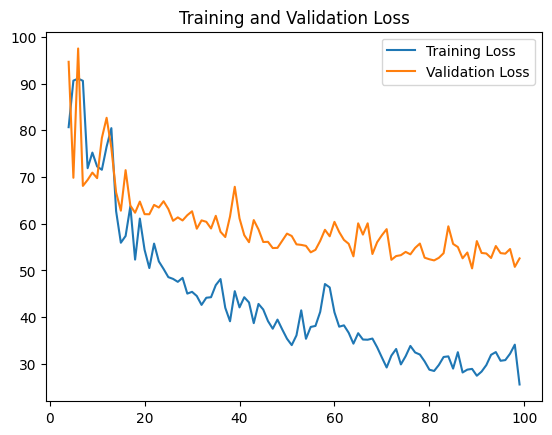

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(4,100)

plt.plot(epochs_range, loss[4:100], label='Training Loss')
plt.plot(epochs_range, val_loss[4:100], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = loaded_model.predict(validation_data[0][0])
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY)*100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] predicting house prices...
3/3 [==============================] - 1s 355ms/step
[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 50.13%, std: 56.74%


In [26]:
validation_data[0][0].shape

(91, 64, 64, 3)

In [28]:
# @title
def predict(bedrooms, bathrooms, area, zipcode,images_path):
  bed_bath_area=abs((np.array([bedrooms,bathrooms,area])-np.array([  1.  , 1., 701.]))/(np.array([1.0e+01 ,6.5e+00 ,7.0e+03])-np.array([  1.  , 1. ,701.])))
  zipBinarizer = LabelBinarizer().fit([91901, 92276, 92677, 92880, 93446, 93510, 94501])
  inputCategorical = zipBinarizer.transform([zipcode])
  inputs = np.hstack([list(inputCategorical.ravel()), list(bed_bath_area)])
  pathimages=[]
  for image in os.listdir(images_path):
    pathh = os.path.sep.join([images_path,image])
    pathimages.append(pathh)
  pathimages.sort()
  print(pathimages)
  inputImages = []
  outputImage = np.zeros((64, 64, 3), dtype="uint8")
  # loop over the input house paths
  for housePath in pathimages:
    # load the input image, resize it to be 32 32, and then
    # update the list of input images
    image = cv2.imread(housePath)
    image = cv2.resize(image, (32, 32))
    inputImages.append(image)

  outputImage[0:32, 0:32] = inputImages[0]
  outputImage[0:32, 32:64] = inputImages[1]
  outputImage[32:64, 32:64] = inputImages[2]
  outputImage[32:64, 0:32] = inputImages[3]
  num_data=inputs.reshape(1,10)
  image_data=outputImage.reshape(1,64,64,3)
  image_data = image_data / 255.0
  preds = loaded_model.predict( image_data)
  return preds
  # diff = preds.flatten() - testY
  # percentDiff = (diff / testY) * 100
  # absPercentDiff = np.abs(percentDiff)

predict(2,1,2690,92276,'/content/my_house')*5858000

['/content/my_house/bathroom.jpg', '/content/my_house/bedroom.jpg', '/content/my_house/frontal.jpg', '/content/my_house/kitchen.jpg']
1/1 [==============================] - 0s 416ms/step


array([[137530.30205145]])